In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install pycocotools


In [ ]:
! pip install --upgrade opencv-python
! pip install --upgrade opencv-python-headless


In [7]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.patches as patches
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import copy



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


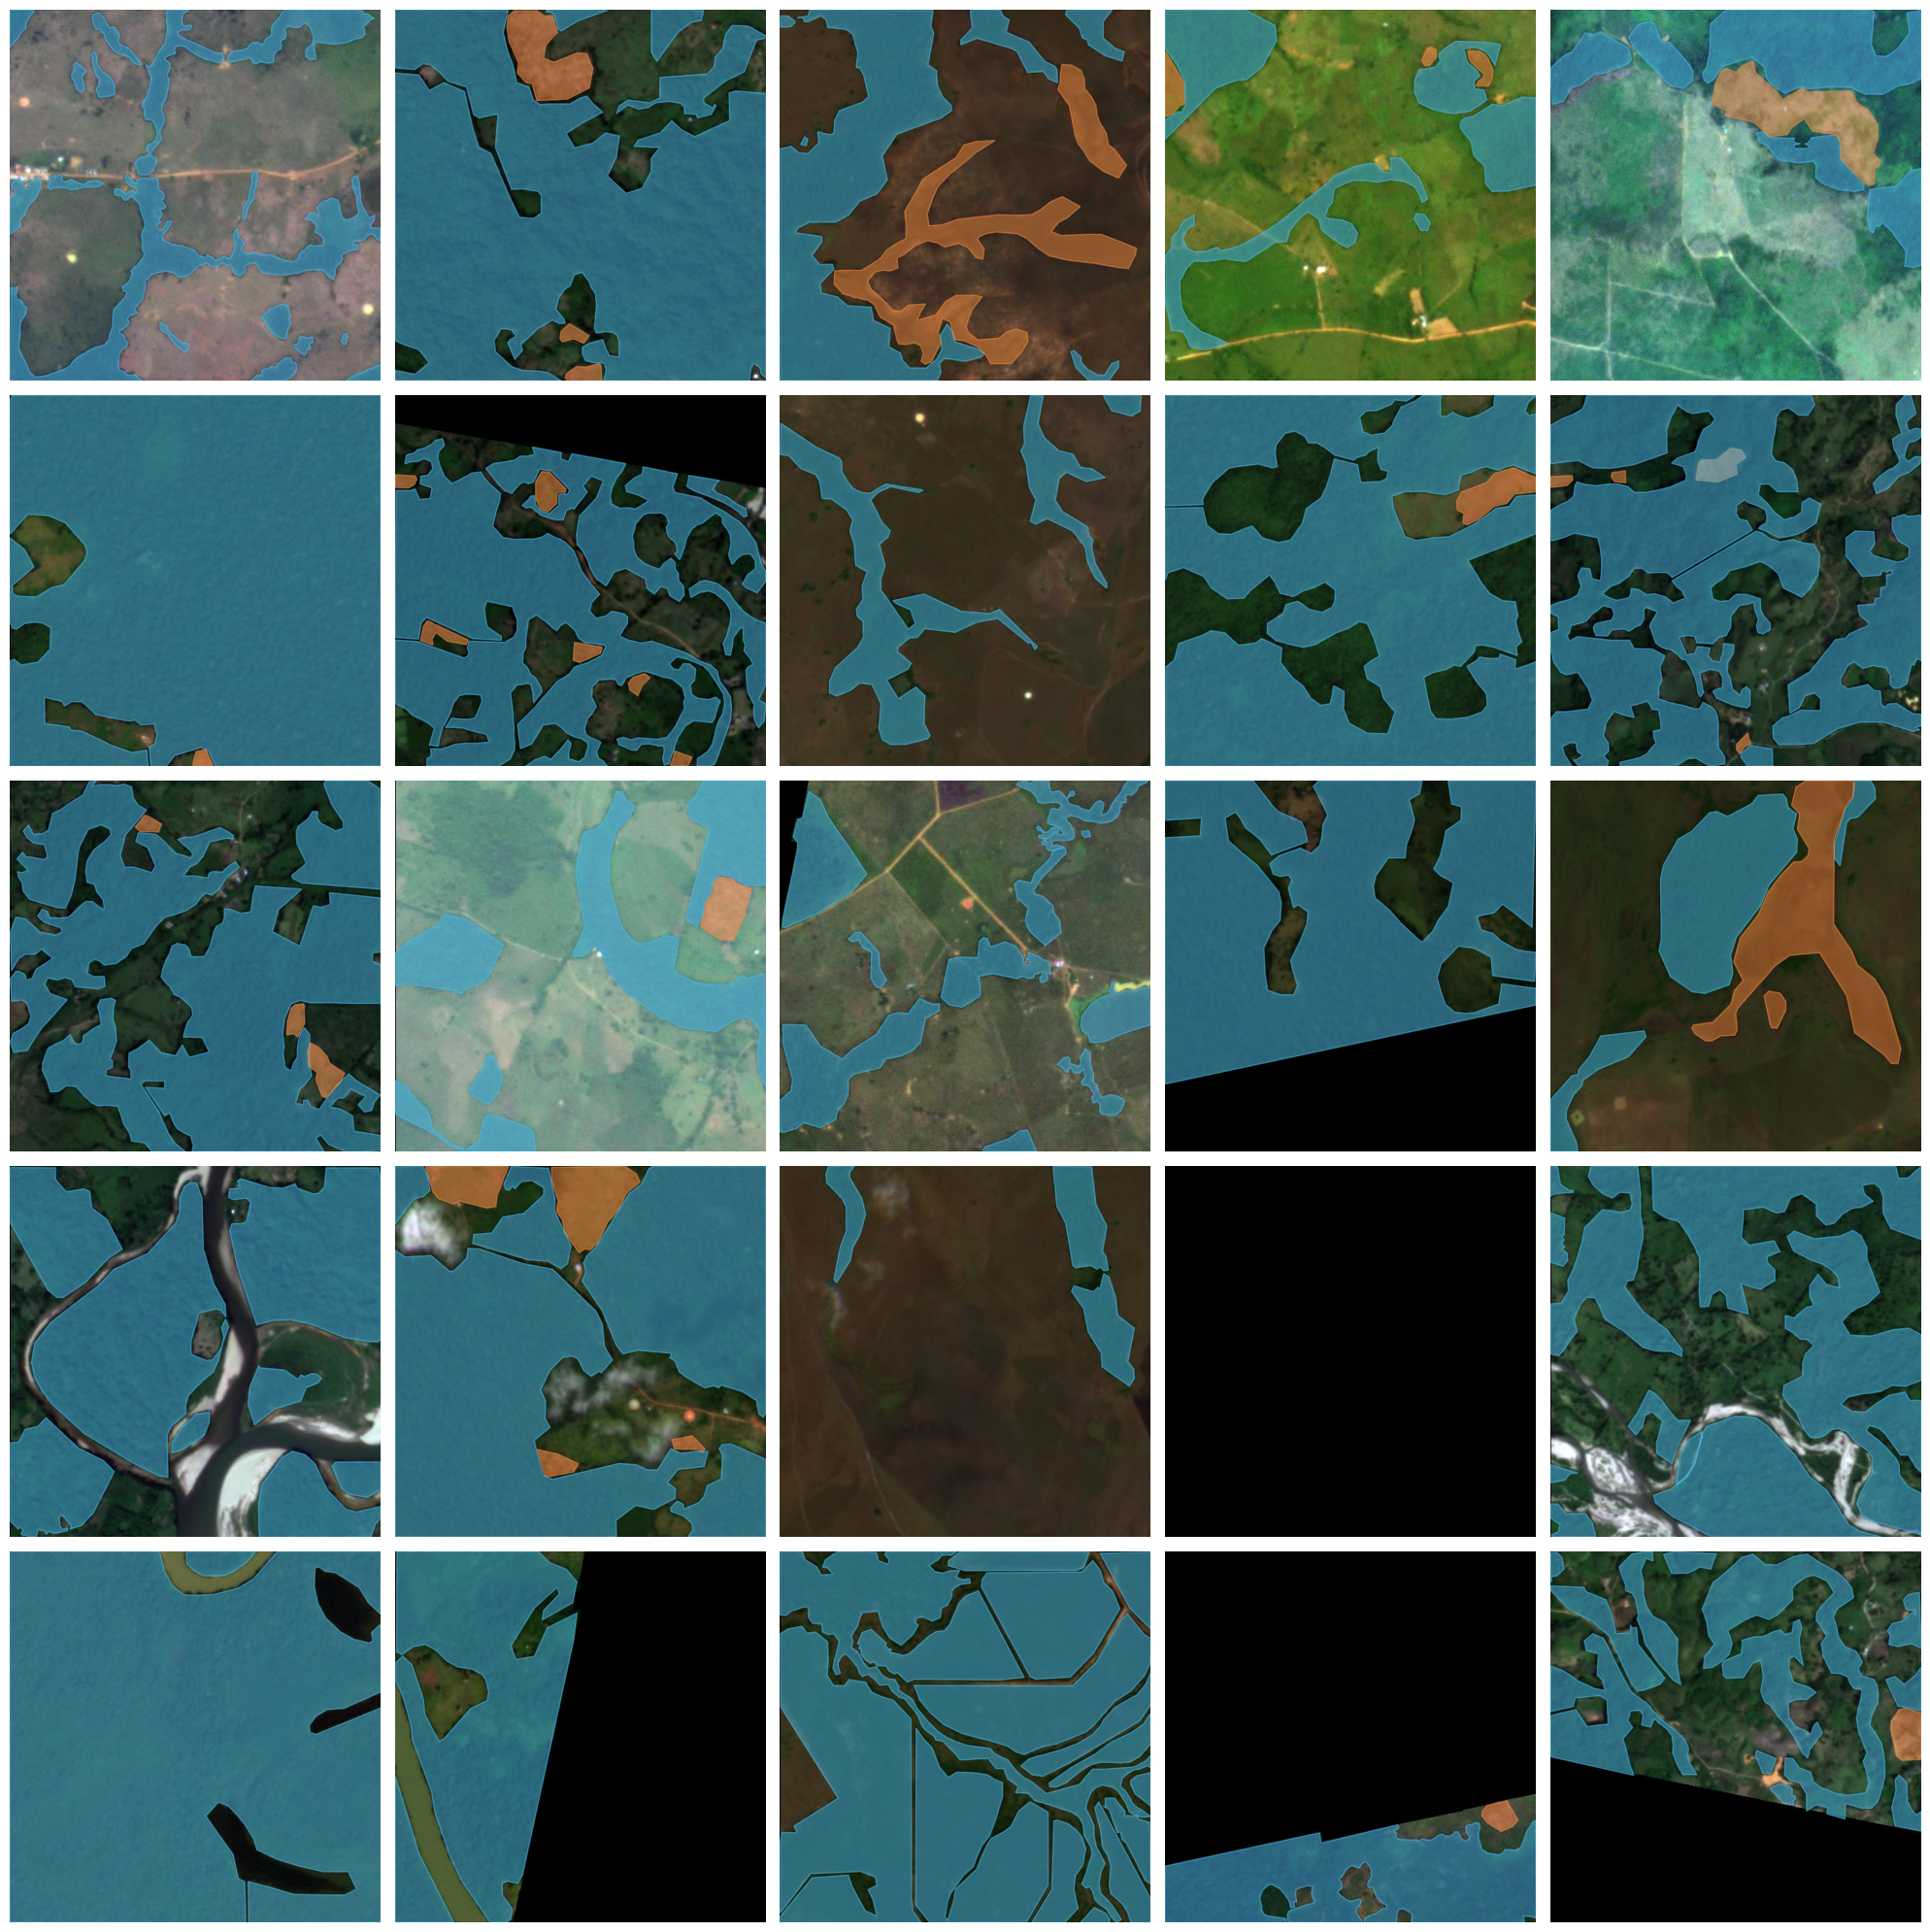

In [13]:

annotations_file = '/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/train/_annotations.coco.json'

# Load the COCO dataset
coco = COCO(annotations_file)

# Filter for specific categories
selected_category_names = ['deforestation', 'forest']

# Get category IDs for the selected categories
selected_category_ids = coco.getCatIds(catNms=selected_category_names)

# Load the selected categories
categories = coco.loadCats(selected_category_ids)

# Create a color map for the selected categories
category_colors = {
    'forest': [0.3, 0.74, 0.93],  # Blue (Color-blind friendly)
    'deforestation': [0.95, 0.55, 0.25]  # Orange (Color-blind)
}

# Get a list of all image IDs
image_ids = coco.getImgIds()

# Create a 5x5 grid for displaying 25 images
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Visualize 25 images in the grid
for i in range(25):
    # Load the metadata of the i-th image
    image_info = coco.loadImgs(image_ids[i])[0]

    # Get annotation IDs for the selected image
    annotation_ids = coco.getAnnIds(imgIds=image_info['id'], catIds=selected_category_ids)

    # Load the annotations for the selected image
    annotations = coco.loadAnns(annotation_ids)

    # Load the image
    image_path = '/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/train/' + image_info['file_name']
    image = cv2.imread(image_path)

    # Plot the image on the corresponding subplot
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')  # Hide the axes

    # Overlay the annotations with the assigned color
    ax = axs[i]

    for annotation in annotations:
        category_id = annotation['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        color = category_colors[category_name]  # Get the color for the current category

        # Draw segmentation (if available)
        if 'segmentation' in annotation:
            for seg in annotation['segmentation']:
                poly = patches.Polygon(np.array(seg).reshape((-1, 2)), linewidth=1, edgecolor=color, facecolor=color, alpha=0.5)
                ax.add_patch(poly)


# Adjust layout
plt.tight_layout()
plt.show()


In [3]:
class COCODataset(Dataset):
    def __init__(self, coco, img_dir, category_ids, transform=None):
        self.coco = coco
        self.img_dir = img_dir
        self.image_ids = coco.getImgIds()
        self.category_ids = category_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # Load the image
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Print image shape and type
        print(f"Image shape: {image.shape}, Image dtype: {image.dtype}")

        # Generate the mask
        mask = self.coco_to_mask(img_info)

        # Print mask shape and unique values
        print(f"Mask shape: {mask.shape}, Mask unique values: {np.unique(mask)}")

        # Apply transformations (if any)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert image to tensor and mask to tensor
        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask, dtype=torch.long)

        # Print tensor shapes
        print(f"Image tensor shape: {image.shape}, Mask tensor shape: {mask.shape}")

        return image, mask

    def coco_to_mask(self, img_info):
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        annotation_ids = self.coco.getAnnIds(imgIds=img_info['id'], catIds=self.category_ids)
        annotations = self.coco.loadAnns(annotation_ids)
        for annotation in annotations:
            for seg in annotation['segmentation']:
                poly = np.array(seg).reshape((-1, 2))
                cv2.fillPoly(mask, [poly.astype(np.int32)], annotation['category_id'])
        return mask

Image shape: (512, 512, 3), Image dtype: uint8
Mask shape: (512, 512), Mask unique values: [0 1 2]
Image tensor shape: torch.Size([3, 512, 512]), Mask tensor shape: torch.Size([512, 512])
Image tensor shape: torch.Size([3, 512, 512])
Mask tensor shape: torch.Size([512, 512])


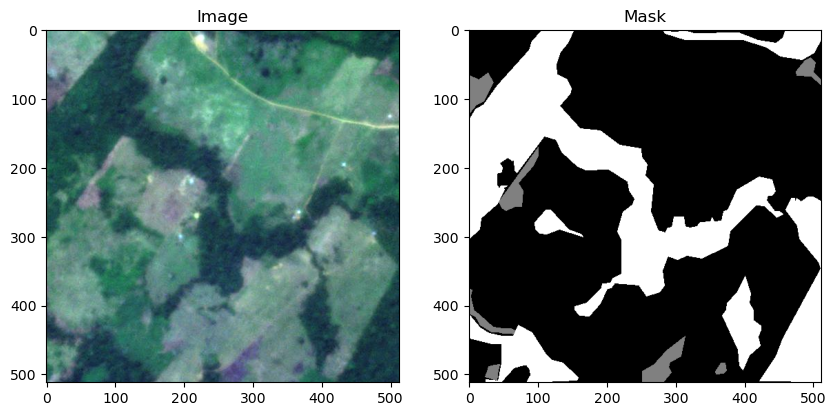

In [5]:
# 1 for 'deforestation', gray; 2 for 'forest', White
image, mask = train_dataset[50]

# Print the shapes to understand the tensor dimensions
print(f"Image tensor shape: {image.shape}")
print(f"Mask tensor shape: {mask.shape}")

# Convert the image tensor back to a NumPy array for visualization
image_np = image.permute(1, 2, 0).numpy()  # Change from [C, H, W] to [H, W, C]

# Visualize the image and the mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image_np)

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.show()


In [6]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # Define the encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Define the decoder with upsampling
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder with upsampling
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Output layer
        out = self.out(dec1)

        return out
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [4]:
# Create datasets and dataloaders
train_dataset = COCODataset(
    coco_file='/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/train/_annotations.coco.json',
    image_dir='/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/train/',
    transform=transform
)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)  # Reduced batch size

valid_dataset = COCODataset(
    coco_file='/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/valid/_annotations.coco.json',
    image_dir='/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/valid/',
    transform=transform
)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)  # Reduced batch size

test_dataset = COCODataset(
    coco_file='/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/test/_annotations.coco.json',
    image_dir='/content/gdrive/MyDrive/Colab Notebooks/forest_2nd_intent/test/',
    transform=transform
)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)  # Reduced batch size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model 
model = UNet(in_channels=3, out_channels=1).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# Training loop
num_epochs = 20
train_losses = []
valid_losses = []
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            # Ensure the target mask has the same shape as the output
            masks = masks.squeeze(1)  # Remove the extra dimension
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation step
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in valid_dataloader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            with autocast():
                val_outputs = model(val_images)
                # Ensure the target mask has the same shape as the output
                val_masks = val_masks.squeeze(1)  # Remove the extra dimension
                val_loss = criterion(val_outputs, val_masks)

            val_running_loss += val_loss.item() * val_images.size(0)

    val_epoch_loss = val_running_loss / len(valid_dataloader.dataset)
    valid_losses.append(val_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}")

    # Save the best model
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

# Load the best model weights
model.load_state_dict(best_model_wts)
print("Training complete. Best model saved.")

Epoch 1/20, Training Loss: 0.0221
Epoch 1/20, Validation Loss: 0.0151
Epoch 2/20, Training Loss: 0.0145
Epoch 2/20, Validation Loss: 0.0149
Epoch 3/20, Training Loss: 0.0145
Epoch 3/20, Validation Loss: 0.0149
Epoch 4/20, Training Loss: 0.0145
Epoch 4/20, Validation Loss: 0.0148
Epoch 5/20, Training Loss: 0.0144
Epoch 5/20, Validation Loss: 0.0149
Epoch 6/20, Training Loss: 0.0144
Epoch 6/20, Validation Loss: 0.0148
Epoch 7/20, Training Loss: 0.0143
Epoch 7/20, Validation Loss: 0.0148
Epoch 8/20, Training Loss: 0.0143
Epoch 8/20, Validation Loss: 0.0147
Epoch 9/20, Training Loss: 0.0143
Epoch 9/20, Validation Loss: 0.0147
Epoch 10/20, Training Loss: 0.0143
Epoch 10/20, Validation Loss: 0.0147
Epoch 11/20, Training Loss: 0.0143
Epoch 11/20, Validation Loss: 0.0147
Epoch 12/20, Training Loss: 0.0143
Epoch 12/20, Validation Loss: 0.0148
Epoch 13/20, Training Loss: 0.0143
Epoch 13/20, Validation Loss: 0.0147
Epoch 14/20, Training Loss: 0.0143
Epoch 14/20, Validation Loss: 0.0147
Epoch 15/2